Data source:
https://www.kaggle.com/datasets/venky73/spam-mails-dataset

In [1]:
import nltk
import pandas as pd
import random
import string
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from nltk.corpus import stopwords

In [2]:
# Create lists of spam and ham emails
df = pd.read_csv('completeSpamAssassin.csv')
df.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


In [3]:
df.shape

(6046, 3)

In [4]:
df.isna().any()

Unnamed: 0    False
Body           True
Label         False
dtype: bool

In [5]:
df = df.dropna()[['Body', 'Label']].reset_index(drop=True)

In [6]:
# function that cleans the Body column removing unnecesary noise
def text_preprocessing(text):
    # convert  text to lowecase
    text = text.lower()
    
    # creating list of words in email
    text = nltk.word_tokenize(text)
    
    # removing special charecters
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    # copying processed text to text and clearing y to store next steps output
    text = y[:]
    y.clear()
    
    # removing stopwords and punctuation marks
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
        
    return " ".join(y)

In [7]:
df['Body'] = df['Body'].apply(text_preprocessing)

In [8]:
df.head()

,Body,Label
0,save 70 life insurance spend life quote saving...,1
1,1 fight risk cancer http slim guaranteed lose ...,1
2,1 fight risk cancer http slim guaranteed lose ...,1
3,adult club offers free membership instant acce...,1
4,thought might like 1 slim guaranteed lose lbs ...,1


In [9]:
# create a list of tuples (message, label)
data = []
for i, row in df.iterrows():
    data.append((row['Body'], row['Label']))

In [10]:
# split the data into training and test sets
training_data, test_data = train_test_split(data, test_size=0.2)

In [11]:
# create a list of all words in the training data
all_words = []
for message, label in training_data:
    words = nltk.word_tokenize(message)
    for word in words:
        all_words.append(word.lower())

In [12]:
# create a frequency distribution of all words
all_words_freq = nltk.FreqDist(all_words)

In [13]:
# create a list of the most common words
most_common_words = list(all_words_freq.keys())[:500]

In [14]:
# create the training set
training_set = [(message, label) for (message, label) in training_data]

In [15]:
# create the CountVectorizer
vectorizer = CountVectorizer(vocabulary=most_common_words)

In [16]:
# fit the vectorizer to the training data and create the feature matrix
features = vectorizer.fit_transform([message for (message, label) in training_set])

In [17]:
# create the labels
labels = [label for (message, label) in training_set]

In [18]:
# create a dictionary of models
models = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=0),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVC': SVC(),
    'XGBoost': XGBClassifier(n_estimators=50,random_state=0),
    'Cat Boost': CatBoostClassifier(verbose=0, random_state=0)
}

In [19]:
# function that return the predictions made by the model
def model_prediction(model, test_data):
    # create the test set
    test_set = [(message, label) for (message, label) in test_data]
    # transform the test data using the trained vectorizer and create the test feature matrix
    test_features = vectorizer.transform([message for (message, label) in test_set])
    # create the test labels
    test_labels = [label for (message, label) in test_set]
    # return predictions
    return model.predict(test_features), test_set

In [20]:
# function that calculates some metrics
def model_report(y, y_score):
    print(f'Accuracy = {accuracy_score(y, y_score):.3f}')
    print(f'Precision = {precision_score(y, y_score):.3f}')
    print(f'Recall = {recall_score(y, y_score):.3f}')
    print(f'F1 score = {f1_score(y, y_score):.3f}')

In [21]:
for x in models:
    model = models.get(x)
    print(x)
    print('-'*len(x))
    # fit the model to the training data
    model.fit(features, labels)
    predictions, test_set = model_prediction(model, test_data)
    # create the test labels
    test_labels = [label for (message, label) in test_set]
    # evaluate the model on the test set
    model_report(predictions, test_labels)
    print()

Multinomial Naive Bayes
-----------------------
Accuracy = 0.888
Precision = 0.718
Recall = 0.891
F1 score = 0.795

Logistic Regression
-------------------
Accuracy = 0.930
Precision = 0.932
Recall = 0.850
F1 score = 0.889

Random Forest
-------------
Accuracy = 0.933
Precision = 0.926
Recall = 0.862
F1 score = 0.893

Gradient Boosting
-----------------
Accuracy = 0.902
Precision = 0.704
Recall = 0.959
F1 score = 0.812

SVC
---
Accuracy = 0.868
Precision = 0.581
Recall = 0.968
F1 score = 0.726

XGBoost
-------
Accuracy = 0.935
Precision = 0.921
Recall = 0.870
F1 score = 0.895

Cat Boost
---------
Accuracy = 0.935
Precision = 0.918
Recall = 0.875
F1 score = 0.896



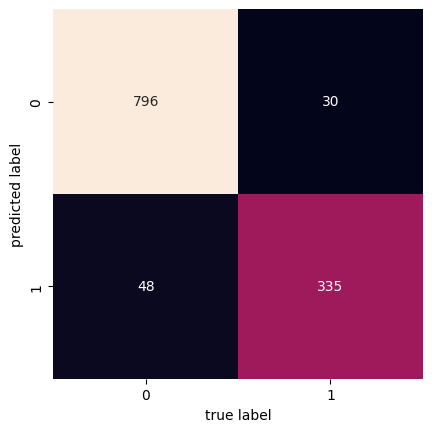

In [22]:
# given the results above, let's see the confusion matrics for the XGBoost model
model = XGBClassifier(n_estimators=50,random_state=0)
model.fit(features, labels)

# compute the confusion matrix
mat = confusion_matrix(y_true=test_labels, y_pred=predictions)

# plot confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');